In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import EDMD, DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si
import time

## Importing the HF solution data

In [2]:
pist_pressure = np.load("../DATA/nonlin_Fsi_Results/nln_pist_pressure.npy")
nnt = pist_pressure.shape[0]
moving_mesh = np.load("../DATA/nonlin_Fsi_Results/nln_moving_mesh.npy")
delta_t = np.load("../DATA/nonlin_Fsi_Results/nln_delta_t.npy")
sol_accel = np.load("../DATA/nonlin_Fsi_Results/nln_sol_accel.npy")
velocity = np.load("../DATA/nonlin_Fsi_Results/nln_fl_velocity_end.npy")[0, :]

t = np.cumsum(delta_t)
nx = moving_mesh.shape[0]
nt = pist_pressure.shape[0]
L = 1
L0 = 1
mass = 1000
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid

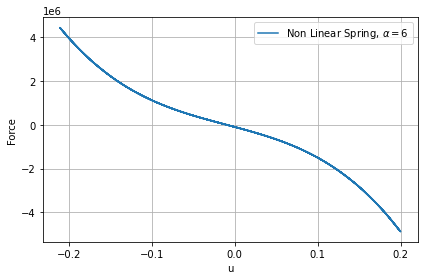

In [3]:
force = mass * sol_accel - pist_pressure
plt.plot(moving_mesh[-1, :] - L0, force, label=r"Non Linear Spring, $\alpha = 6$")
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();

**Interpolating on an equally sampled time grid**

In [4]:
# Choose number of equally spaced timesteps 
dt = delta_t.min()

# Interpolating original data to the new timesteps
target_t = np.arange(t[0], t[-1]+dt, dt)
ntt = target_t.shape[0]
target_pist_pressure = si.griddata(t, pist_pressure.T, target_t, method='linear').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='linear').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='linear').T
target_velocity = si.griddata(t, velocity.T, target_t, method='linear').T

**Separating training and testing data**

In [5]:
Coeff = 0.75
train_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, :int(Coeff*ntt)]-L0
train_pres = target_pist_pressure.reshape((1, -1))[:, :int(Coeff*ntt)]
train_sol_accel = target_sol_accel.reshape((1, -1))[:, :int(Coeff*ntt)]
train_velocity = target_velocity.reshape((1, -1))[:, :int(Coeff*ntt)]
train_t = target_t[:int(Coeff*ntt)]

test_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, int(Coeff*ntt)::]-L0
test_pres = target_pist_pressure.reshape((1, -1))[:, int(Coeff*ntt)::]
test_sol_accel = target_sol_accel.reshape((1, -1))[:, int(Coeff*ntt)::]
test_velocity = target_velocity.reshape((1, -1))[:, int(Coeff*ntt)::]
test_t = target_t[int(Coeff*ntt)::]

X = train_disp[:1, :-1]
Y = np.vstack((train_sol_accel[:1, 1::], train_disp[:1, 1::], train_velocity[:1, 1::]))
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : train_pres[:, :-1]],  
               "Y" : [lambda x : x]}


## eDMD learning

In [6]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [7]:
edmd.A

array([[-1.00782998e+04, -9.08729070e+03, -2.99880365e+05,
        -1.09936132e+02,  1.09455165e-03],
       [ 9.99802903e-01,  1.14707982e-03, -3.44592385e-04,
         9.23563883e-05, -1.33560546e-09],
       [-2.74117367e+01,  1.59761538e+02, -4.74390911e+01,
         1.28392982e+01, -1.85755132e-04]])

The model did learn the correct spring parameters, (see [the eDMD Spring notebook](./eDMD_Spring.ipynb) )

## The prediction phase

Now that these parameters are known we can solve the following ODE for $\pmb{u(t)}$ and $\pmb{v(t)}$

$$(ODE1) : \pmb{\dot{y}} = 
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix} = f(\pmb{y}, t)$$
$d(t) = d_1 + d_2 * p(t)$

In [8]:
pred_t = test_t.copy()
input_ = np.vstack((test_disp[:1, :], test_disp[:1, :]**2, test_disp[:1, :]**3, np.ones((1,len(pred_t))), test_pres))
pred = np.real(drom.predict(pred_t, x_input = input_))

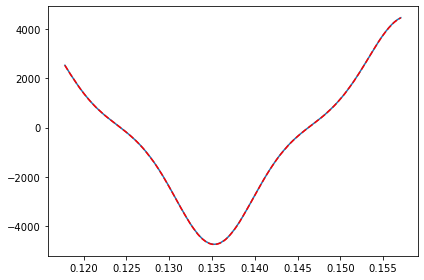

In [9]:
plt.plot(test_t, pred[0, :]);
plt.plot(test_t, test_sol_accel[0, :], 'r--');
plt.tight_layout();